In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip install pytorch_lightning wandb

  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/823.1 kB ? eta -:--:--
   --------------------------------------- 823.1/823.1 kB 18.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/22.5 MB ? eta -:--:--
   --------- ------------------------------ 5.2/22.5 MB 26.5 MB/s eta 0:00:01
   ---------------- ----------------------- 9.4/22.5 MB 22.6 MB/s eta 0:00:01
   -------------------------- ------------- 14.9/22.5 MB 24.1 MB/s eta 0:00:01
   ----------------------------------- ---- 20.2/22.5 MB 24.1 MB/s eta 0:00:01
   ---------------------------------------- 22.5/22.5 MB 23.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 2.0/2.0 MB 27.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
    --------------------------------------- 5.2/216.1 MB 24.5 MB/s eta 0:00:09
   - ----------------------

In [5]:
!pip install Biopython

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 18.3 MB/s eta 0:00:00


In [6]:
import wandb
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import numpy as np
from tqdm import tqdm
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, explained_variance_score

from genome import parse_gff, get_chromosome_lengths, get_chromosome_valid_genes
from data import get_data_loader
from models import LinearModel, ConvolutionalModel

In [7]:
chrom_lengths = get_chromosome_lengths("../data/genome/fasta_file.fsa")
cds_coords = parse_gff("../data/genome/gff_file.gff")

FileNotFoundError: [Errno 2] No such file or directory: '../data/genome/fasta_file.fsa'

In [74]:
chr_valid_genes = get_chromosome_valid_genes(cds_coords, chrom_lengths)

In [75]:
holdout = ["chrVIII"]
folds = [
    ['chrI', 'chrII', 'chrIII'],
    ['chrIV', 'chrV', 'chrVI'],
    ['chrVII', 'chrIX', 'chrX'],
    ['chrXI', 'chrXII', 'chrXIII'],
    ['chrXIV', 'chrXV', 'chrXVI'],
]

In [76]:
# holdout = ["chrVIII"]
# folds = [
#     ['chrI'],
#     ['chrII'],
#     ['chrIII']
# ]

In [77]:
for i in range(len(folds)):
  test_chromosomes = folds[i]
  train_chromosomes = []
  for j in range(len(folds)):
    if i != j:
      train_chromosomes += folds[j]

  model = ConvolutionalModel(pooling_type="max", learning_rate=1e-3)


  train_dataloader = get_data_loader(train_chromosomes, chr_valid_genes, batch_size=64, cache_size=100)
  test_dataloader = get_data_loader(test_chromosomes, chr_valid_genes, batch_size=64, cache_size=100)

  wandb_logger = WandbLogger(project="RNA_prediction", name=f"fold_{i}, max convolution, lr=1e-3, batch_size=64")

  trainer = pl.Trainer(max_epochs=20, logger=wandb_logger)
  trainer.fit(model, train_dataloader, test_dataloader)

  wandb.finish()

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | conv    | Conv1d  | 13.8 K | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
13.8 K    Trainable params
0         Non-trainable params
13.8 K    Total params
0.055     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/nico/Software/uni/ML4RG/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss,██▇▆▆▃▅▄▂▇▄▂▅▂▃▆▆▃▄▃▆▄▂▄▂▁▅▂▄▃▃▃▃▃▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▆▅▃▄▃▃▂▃▂▂▂▂▂▁▂▂▁▂▂
epoch,19
train_loss,0.20238
trainer/global_step,1759
val_loss,0.5375


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | conv    | Conv1d  | 13.8 K | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
13.8 K    Trainable params
0         Non-trainable params
13.8 K    Total params
0.055     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/nico/Software/uni/ML4RG/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_loss,▄█▇▄▆▃▃▃▁▂▄▁▄▅▄▂▁▆▂▁▄▂▂▂▃▄▁▂▂▄▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,19
train_loss,0.27565
trainer/global_step,1579
val_loss,0.41605


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | conv    | Conv1d  | 13.8 K | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
13.8 K    Trainable params
0         Non-trainable params
13.8 K    Total params
0.055     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/nico/Software/uni/ML4RG/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss,▃▃▂█▂▄▄▅▂▃▂▄▄▅▂▃▆▂▃▃▂▂▁▄▂▅▄▂▂▂▂▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,19
train_loss,0.24757
trainer/global_step,1599
val_loss,0.36804


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | conv    | Conv1d  | 13.8 K | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
13.8 K    Trainable params
0         Non-trainable params
13.8 K    Total params
0.055     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/nico/Software/uni/ML4RG/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
train_loss,▆▄▂▄▁▅▃▅▆▄▃▆▃▄▃▃▅█▂▅▅▆▃▃▃▇▅▄█▇
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
val_loss,█▆▄▄▂▂▃▃▂▂▁▂▂▂▂▂▂▂▂▁
epoch,19
train_loss,0.50882
trainer/global_step,1539
val_loss,0.3217


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | conv    | Conv1d  | 13.8 K | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
13.8 K    Trainable params
0         Non-trainable params
13.8 K    Total params
0.055     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/nico/Software/uni/ML4RG/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,█▃▃█▃▅▇▂▃▄▄▁▃▂▃▂▄▅▂▃▅▂▄▁▄▅▃▂▃▄
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
epoch,19
train_loss,0.4147
trainer/global_step,1499
val_loss,0.30095


In [78]:
wandb.finish()

In [80]:
train_chromosomes = []
for j in range(len(folds)):
    train_chromosomes += folds[j]

model = ConvolutionalModel(pooling_type="max", learning_rate=1e-3)

train_dataloader = get_data_loader(train_chromosomes, chr_valid_genes, batch_size=64, cache_size=100)

trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, train_dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | conv    | Conv1d  | 13.8 K | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
13.8 K    Trainable params
0         Non-trainable params
13.8 K    Total params
0.055     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [92]:
torch.save(model.state_dict(), "../models/linear_full_model.pth")

In [81]:
ds_holdout = get_data_loader(holdout, chr_valid_genes, batch_size=16, cache_size=2000)

predictions = []
truth = []
for batch in tqdm(ds_holdout):
    x, y = batch
    y_hat = model(x.float())
    predictions.append(y_hat.detach().cpu().numpy())
    truth.append(y.detach().cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
truth = np.concatenate(truth, axis=0)

100%|██████████| 21/21 [00:02<00:00,  9.55it/s]


In [82]:
correlations = []

for i in range(predictions.shape[1]):
    correlations.append(np.corrcoef(predictions[:, i], truth[:, i])[0, 1])

correlations

[np.float64(0.701262337382678),
 np.float64(0.7364825537049897),
 np.float64(0.7288045770239691),
 np.float64(0.7215559457671806),
 np.float64(0.75226616437259),
 np.float64(0.7302057835212733),
 np.float64(0.6543937666300462),
 np.float64(0.6943423688963055),
 np.float64(0.7213884098049866),
 np.float64(0.6929838764123872),
 np.float64(0.6592674427202262),
 np.float64(0.690289044049368),
 np.float64(0.7377665008077012),
 np.float64(0.6011875798613153),
 np.float64(0.7280409889238874),
 np.float64(0.7367404126086502),
 np.float64(0.6633131540199178),
 np.float64(0.5168801140255789)]

In [ ]:
condition_samples = json.load(open("../data/samples.json"))
conditions = sorted(list(condition_samples.keys()))
conditions

['DNA_damage',
 'alpha_factor',
 'benomyl',
 'calcofluor',
 'congo_red',
 'exponential_growth',
 'grape_juice',
 'heat_shock',
 'high_calcium',
 'hydroxyurea',
 'low_nitrogen',
 'low_phosphate',
 'oxidative_stress',
 'salt',
 'sc_glycerol_media',
 'sc_media',
 'sorbitol',
 'stationary_phase']

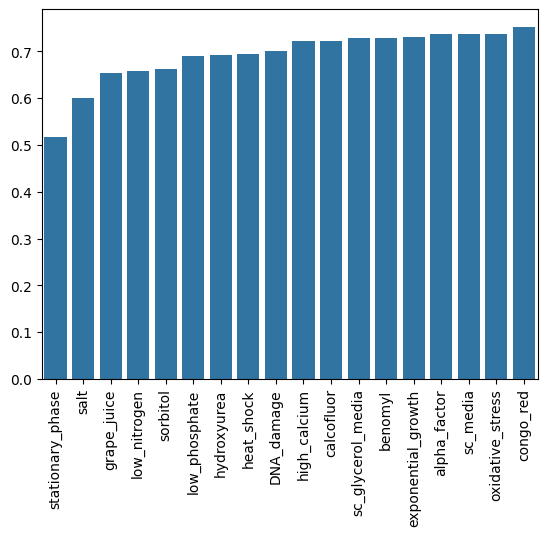

In [87]:
# Sort conditions and correlations by correlation value
sorted_indices = np.argsort(correlations)
sorted_conditions = [conditions[i] for i in sorted_indices]
sorted_correlations = [correlations[i] for i in sorted_indices]

sns.barplot(x=sorted_conditions, y=sorted_correlations)
plt.xticks(rotation=90)
plt.show()

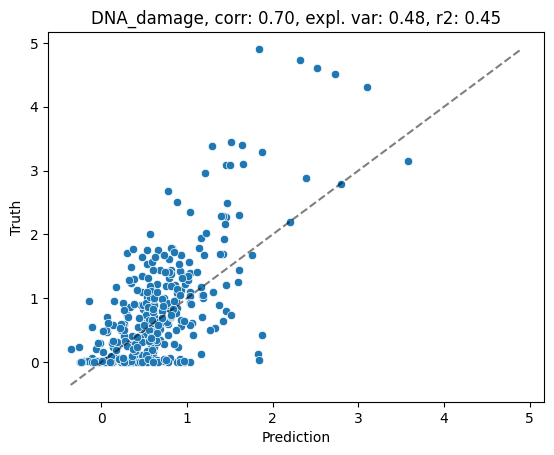

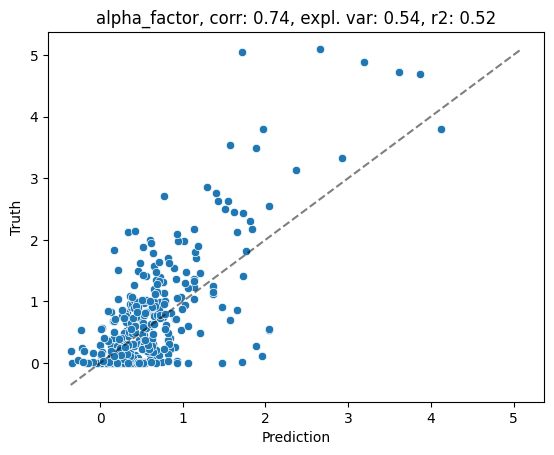

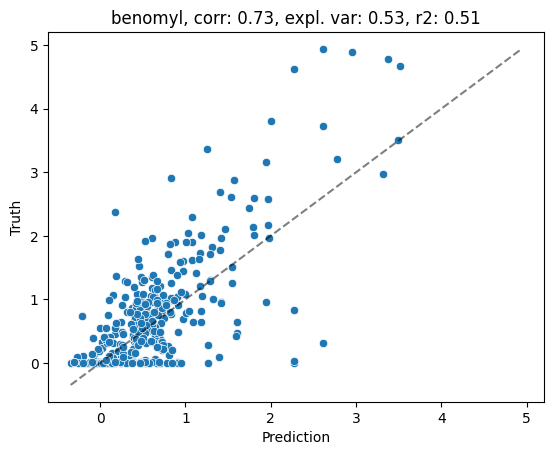

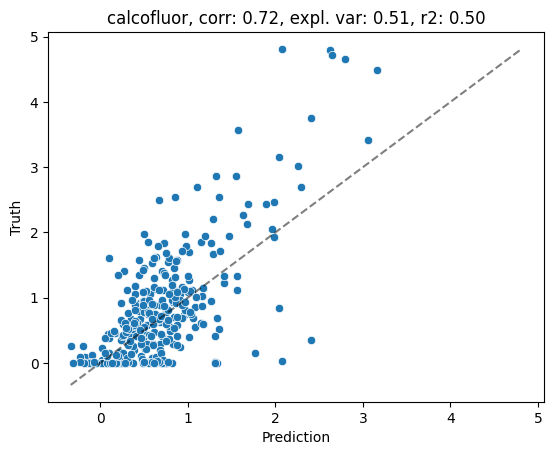

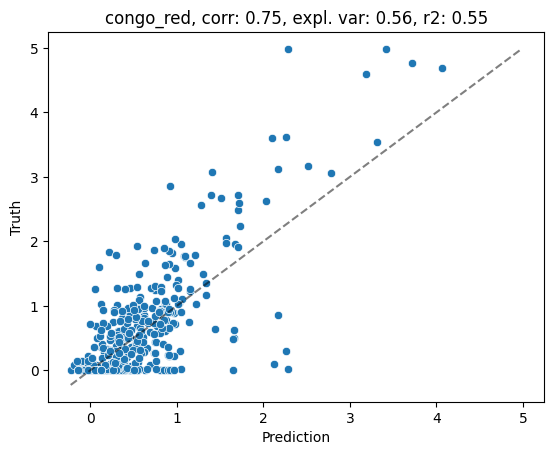

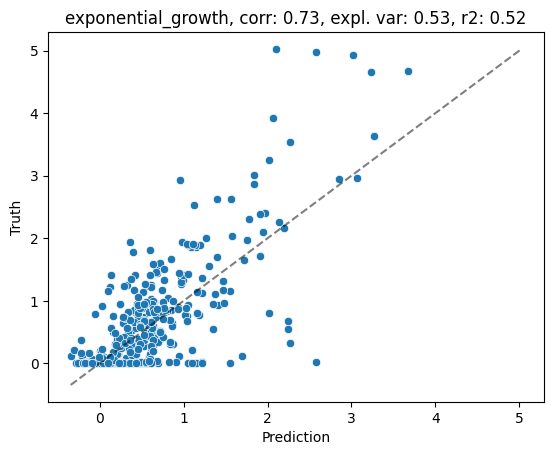

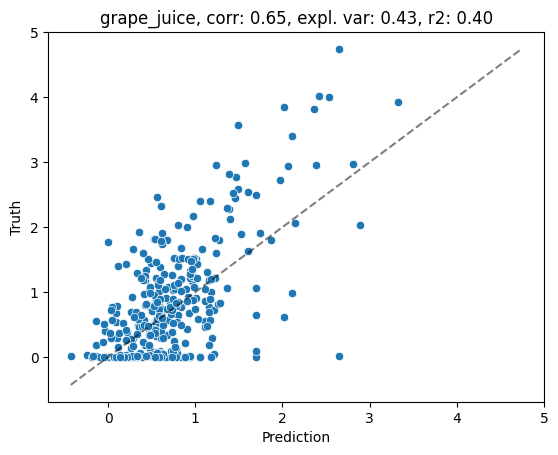

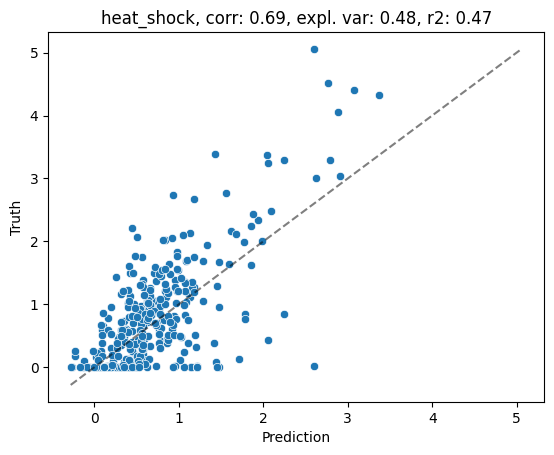

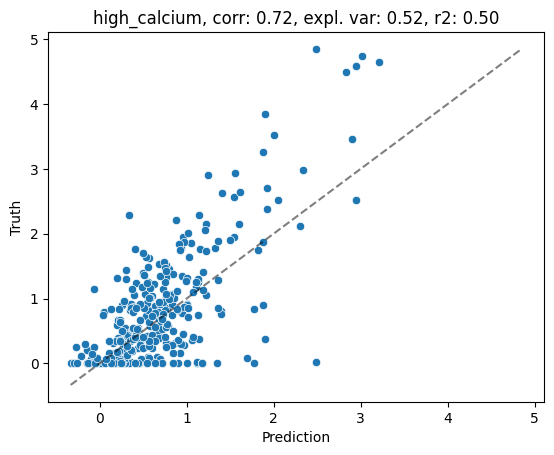

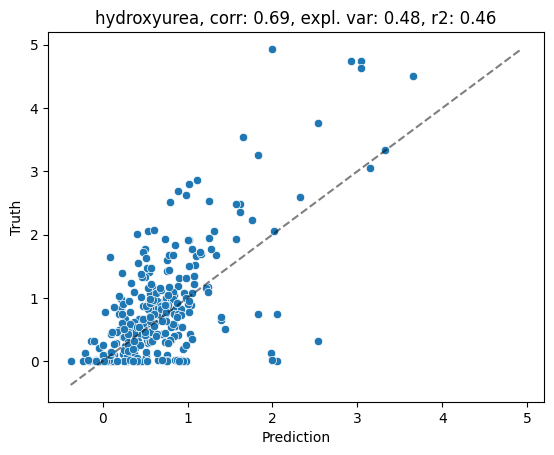

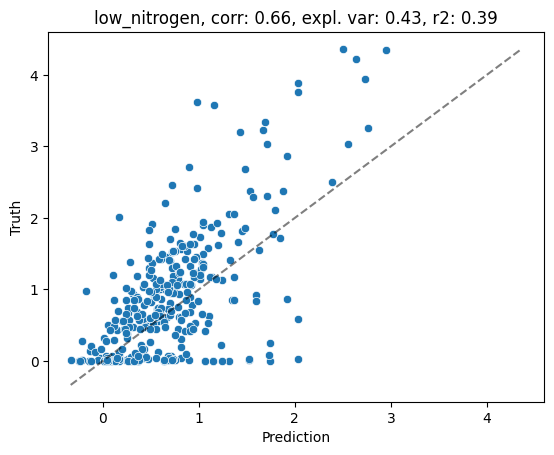

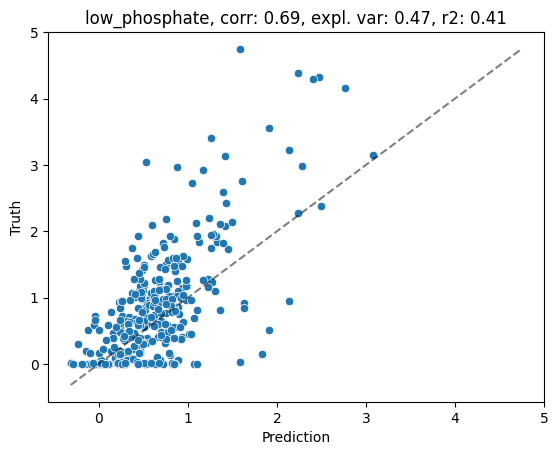

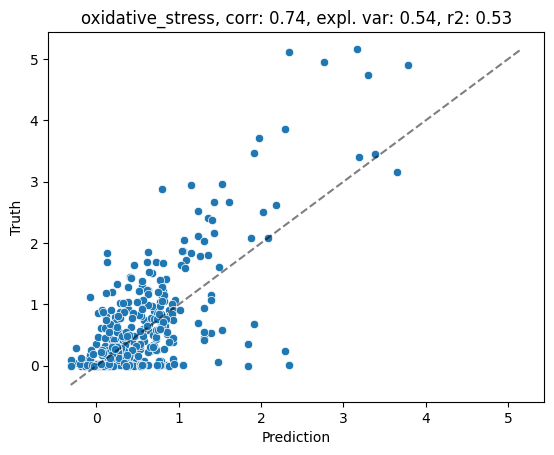

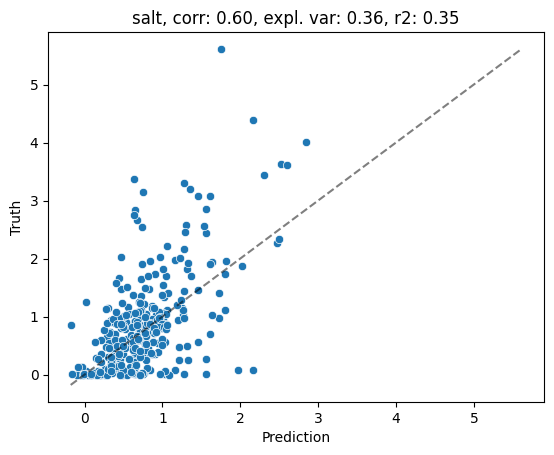

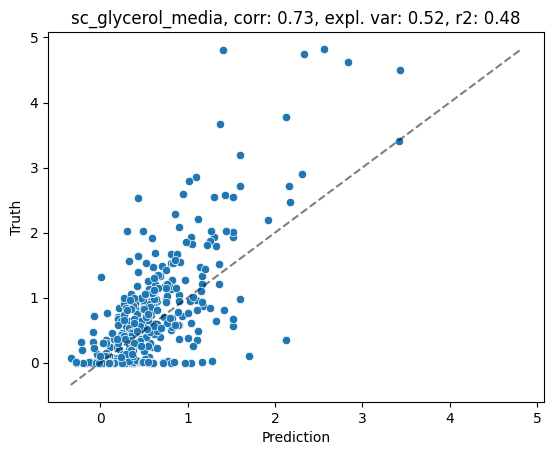

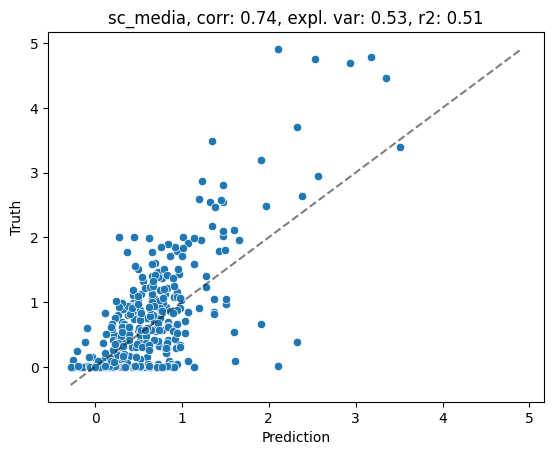

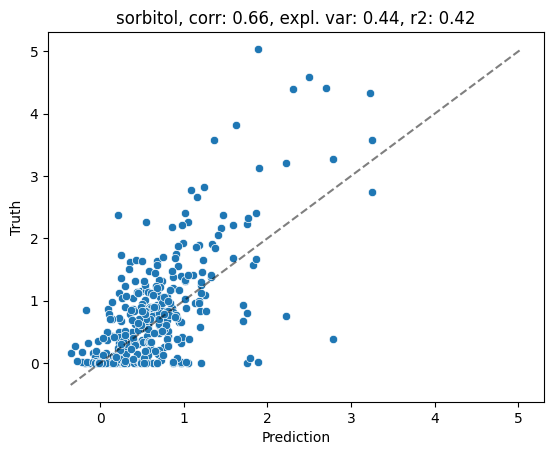

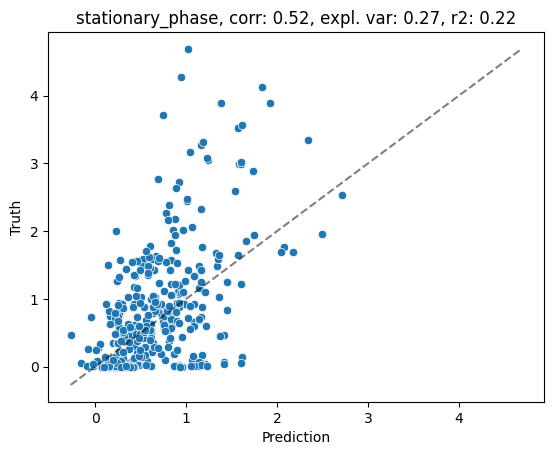

In [88]:
for i, condition in enumerate(conditions):
    p = predictions[:, i]
    t = truth[:, i]
    correlation = np.corrcoef(p, t)[0, 1]
    
    # Explained variance
    explained_variance = explained_variance_score(t, p)
    r2 = r2_score(t, p)
    
    sns.scatterplot(x=p, y=t)
    plt.title(f"{condition}, corr: {correlation:.2f}, expl. var: {explained_variance:.2f}, r2: {r2:.2f}")
    plt.xlabel("Prediction")
    plt.ylabel("Truth")

    # Add diagonal line
    min_val = min(p.min(), t.min())
    max_val = max(p.max(), t.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

    plt.show()